# Random forest predictions
This notebook ingests the positive and negative training vectors as well as the prediction set as generated by the notebook ``ExtractDifferenceVectors.ipynb``. It then perfoms Random forest learning and ranks the prediction set.

In [1]:
import pandas as pd
import os
import sys
import numpy as np
sys.path.insert(0, os.path.abspath('../..'))
from kcet import KcetParser
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn import metrics

In [2]:
target_year = 2014

In [3]:
positive_validation_pickle_path =  "positive-valid-vectors-{}.pkl".format(target_year)
negative_validation_pickle_path =  "negative-valid-vectors-{}.pkl".format(target_year)
positive_train_pickle_path =  "positive-train-vectors-{}.pkl".format(target_year)
negative_train_pickle_path =  "negative-train-vectors-{}.pkl".format(target_year)
diff_vectors_pos_validation = pd.read_pickle(positive_validation_pickle_path)
diff_vectors_neg_validation = pd.read_pickle(negative_validation_pickle_path)
diff_vectors_pos_training = pd.read_pickle(positive_train_pickle_path)
diff_vectors_neg_training = pd.read_pickle(negative_train_pickle_path)

In [4]:
diff_vectors_pos_validation.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene1019-meshd009101,0.338146,1.551510,1.329146,-0.402644,-0.365563,1.229389,-0.564658,-0.725853,-0.475468,1.187158,...,-0.856242,-0.977967,2.262572,0.630957,-0.727329,-1.591636,-0.410532,-1.151967,0.092495,2.686748
ncbigene1021-meshd009101,0.317447,1.592640,1.519619,-0.536371,-0.170899,1.243733,-0.835957,-0.656097,0.117540,0.658455,...,-0.660688,-0.826090,1.723593,0.542812,-1.060600,-1.255378,-0.728818,-0.898970,0.057500,2.787946
ncbigene1019-meshd008228,0.803433,0.167172,1.817424,-0.479587,-0.155410,1.474734,-0.376142,-1.200571,-1.870340,0.098593,...,-0.995378,-1.134235,0.499061,0.762531,-0.978259,-2.810408,-0.473006,-0.992879,-0.731656,1.302718
ncbigene1021-meshd008228,0.782733,0.208303,2.007897,-0.613314,0.039254,1.489079,-0.647440,-1.130815,-1.277333,-0.430110,...,-0.799824,-0.982358,-0.039919,0.674386,-1.311530,-2.474149,-0.791292,-0.739882,-0.766651,1.403916
ncbigene1019-meshd008175,-0.842759,-0.126520,0.936020,-0.910827,0.170698,1.780393,-0.650705,-2.189121,-0.099471,1.637497,...,-0.992617,-0.417344,0.697609,0.308156,-0.883801,-1.503524,-1.023985,-0.728895,-2.233297,1.010963


In [5]:
diff_vectors_pos_validation.shape

(3346, 100)

In [6]:
diff_vectors_neg_validation.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene11011-meshd018303,1.226825,-0.339507,2.179482,0.284105,0.369853,1.081609,-0.541979,-1.464468,1.270841,-2.967746,...,1.805328,-1.984321,1.361329,-0.295953,-2.942528,0.721926,-1.518700,-1.000626,0.484397,1.523645
ncbigene4216-meshd044584,0.558713,-0.632482,1.118587,-0.199439,-0.230775,0.909900,-1.140750,-1.596251,-0.616693,-2.639124,...,0.308823,-0.458321,-0.920378,-0.904570,-1.571379,0.310604,-2.416225,-0.879573,0.838202,1.905286
ncbigene83942-meshd007947,2.371193,1.045901,2.197309,0.885526,1.961992,2.238791,-0.763799,-0.834546,1.789700,-1.839275,...,2.335320,-1.362244,1.878368,-0.410343,-3.021754,0.602881,-0.485488,-0.831752,1.521108,1.799573
ncbigene5592-meshd015461,0.177713,-2.253111,1.312603,0.356687,-0.266335,-0.699278,0.091815,0.926055,0.768275,0.615906,...,0.607859,0.096507,0.505663,0.320432,0.966238,-0.505202,1.187323,0.342524,-0.086668,1.805837
ncbigene6041-meshd002295,-1.059957,-0.440493,-0.646512,-0.801247,0.081256,-0.489672,-0.845159,0.086670,0.179575,0.458194,...,-0.034823,-1.059111,-0.245728,0.299684,-0.047203,-0.177944,0.345582,-0.586977,-0.846100,-0.123348


In [7]:
diff_vectors_pos_training.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene1956-meshd002289,0.084409,-1.678300,0.570391,-0.568099,-0.010835,0.572113,-0.322410,0.739851,1.520667,2.166842,...,-0.575982,-1.295671,1.546393,1.501823,0.745674,-0.125327,0.032880,-0.964539,-1.653759,-1.042141
ncbigene2064-meshd002289,-0.369026,-0.722960,0.209369,-1.060191,0.139762,0.383901,-0.069822,0.742758,1.055592,2.474284,...,-0.220842,-1.920477,1.655190,0.945728,0.002300,0.255939,0.853816,-0.957237,-1.405988,-1.630018
ncbigene25-meshd007938,-0.409652,-0.704031,0.943865,-0.178671,-0.030556,-0.388466,0.692359,-0.573274,-1.647355,1.072487,...,-0.652975,0.923524,1.529238,1.960512,-0.228658,0.389493,0.665099,0.897752,-1.024783,-0.170860
ncbigene6714-meshd007938,1.507067,-2.183508,1.419783,0.323428,-0.333426,0.442277,-0.875432,1.759025,-0.652972,1.885400,...,-1.161514,0.619486,2.542570,0.944245,0.610180,-0.836798,0.085792,0.514709,-1.135671,-0.143010
ncbigene25-meshd015464,-0.667843,0.885112,0.716607,-0.249770,0.432793,-0.240709,0.165606,0.510383,-0.753956,1.141626,...,-0.109709,-0.757855,1.207874,0.851590,0.174275,-0.033072,0.132791,0.057307,-0.072082,0.505899


In [8]:
diff_vectors_neg_training.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene5347-meshd002281,-0.952531,-1.399738,0.269511,-0.028647,-1.652408,-1.206400,-0.168913,-0.503912,-1.950024,-0.734232,...,-1.257468,0.944628,-1.785303,1.168958,0.170774,-2.089142,1.145069,-0.344957,-2.096280,0.299563
ncbigene85366-meshd008039,-0.025281,0.887586,1.094493,0.238148,0.279401,0.937272,-0.265283,-1.578512,-0.297536,-1.310618,...,0.749151,-1.977423,0.805274,-0.596315,-1.546666,0.144302,-0.001451,-1.063803,0.292895,1.403246
ncbigene10783-meshd016411,1.154683,0.510656,2.799820,0.404842,1.386131,1.623741,-1.032787,-0.740099,1.256431,-1.370754,...,1.232125,-2.382311,1.333607,-0.179077,-1.485934,-0.774692,-1.854676,-1.496471,1.072953,2.055417
ncbigene5563-meshd015173,-0.435012,-1.977938,0.672738,-0.390963,-1.177326,-0.126279,-0.275651,-0.345940,0.572879,-1.007640,...,-0.372460,-0.243397,-0.490902,2.199644,-0.282625,-0.542096,1.089278,-0.626351,0.605970,0.531872
ncbigene5582-meshd018234,0.584305,-1.314316,0.432097,0.292354,-0.690946,-0.239998,-1.701737,-0.047945,-1.276362,-0.368982,...,0.584647,-0.702794,0.031270,-0.503160,-0.217181,-0.220165,-0.809614,-0.442429,-0.244212,0.911784


# Random Forest
### 1. Training set
Create the training set by concatenating ``diff_vectors_pos`` and ``diff_vectors_neg``.

In [9]:
X_train = pd.concat([diff_vectors_pos_training,diff_vectors_neg_training])
print("Total training vectors: %d" % len(X_train))

Total training vectors: 2280


In [10]:
label_1 = np.ones(diff_vectors_pos_training.shape[0])
label_0 = np.zeros(diff_vectors_neg_training.shape[0])
y_train = np.concatenate((label_1,label_0))
print("Total training labels: %d" % len(y_train))

Total training labels: 2280


### 2. Test set. 

In [11]:
X_test = pd.concat([diff_vectors_pos_validation,diff_vectors_neg_validation])
print("Total test vectors: %d" % len(X_test))

Total test vectors: 5448


In [12]:
label_1 = np.ones(diff_vectors_pos_validation.shape[0])
label_0 = np.zeros(diff_vectors_neg_validation.shape[0])
y_test = np.concatenate((label_1,label_0))
print("Total test labels: %d" % len(y_test))

Total test labels: 5448


In [13]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene1019-meshd009101,0.338146,1.551510,1.329146,-0.402644,-0.365563,1.229389,-0.564658,-0.725853,-0.475468,1.187158,...,-0.856242,-0.977967,2.262572,0.630957,-0.727329,-1.591636,-0.410532,-1.151967,0.092495,2.686748
ncbigene1021-meshd009101,0.317447,1.592640,1.519619,-0.536371,-0.170899,1.243733,-0.835957,-0.656097,0.117540,0.658455,...,-0.660688,-0.826090,1.723593,0.542812,-1.060600,-1.255378,-0.728818,-0.898970,0.057500,2.787946
ncbigene1019-meshd008228,0.803433,0.167172,1.817424,-0.479587,-0.155410,1.474734,-0.376142,-1.200571,-1.870340,0.098593,...,-0.995378,-1.134235,0.499061,0.762531,-0.978259,-2.810408,-0.473006,-0.992879,-0.731656,1.302718
ncbigene1021-meshd008228,0.782733,0.208303,2.007897,-0.613314,0.039254,1.489079,-0.647440,-1.130815,-1.277333,-0.430110,...,-0.799824,-0.982358,-0.039919,0.674386,-1.311530,-2.474149,-0.791292,-0.739882,-0.766651,1.403916
ncbigene1019-meshd008175,-0.842759,-0.126520,0.936020,-0.910827,0.170698,1.780393,-0.650705,-2.189121,-0.099471,1.637497,...,-0.992617,-0.417344,0.697609,0.308156,-0.883801,-1.503524,-1.023985,-0.728895,-2.233297,1.010963


## Hyperparameter tuning the random forest.

In [14]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
#Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 5, 7, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, None], 'min_samples_split': [2, 3, 5, 7, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


## Search over the parameters to choose the best model

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 1, cv = 10, verbose=2, random_state=42)

rf_random.fit(X_train,y_train)

best_model = rf_random.best_estimator_

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.1s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.9s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.9s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.2s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.0s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.2s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;

In [16]:
rf_random.best_params_


{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': False}

# Link prediction

In [17]:
y_pred = best_model.predict(X_test)
yproba = best_model.predict_proba(X_test)[::,1]
#y_pred

In [18]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.44      1.00      0.62      2102
         1.0       0.99      0.22      0.36      3346

    accuracy                           0.52      5448
   macro avg       0.72      0.61      0.49      5448
weighted avg       0.78      0.52      0.46      5448



In [19]:
metrics.confusion_matrix(y_test,y_pred)

array([[2096,    6],
       [2616,  730]])

In [20]:
fpr, tpr, _ = roc_curve(y_test,  yproba)
auc_test = roc_auc_score(y_test, yproba)

In [21]:
auc_test

0.937346053597661

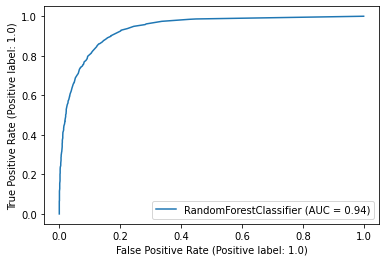

In [22]:
metrics.plot_roc_curve(best_model, X_test, y_test)  

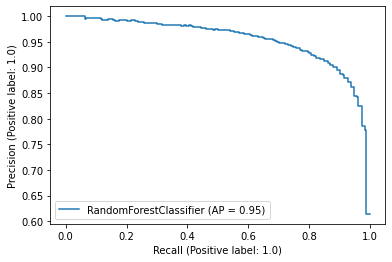

In [23]:
metrics.plot_precision_recall_curve(best_model, X_test, y_test)

## Decoding results
The ``KcetParser`` class has methods that take the raw X_test vectors and create an annotated dataframe by
decoding strings like ``ncbigene5599-meshd000074723`` to show the corresponding gene symbols and MeSH labels (neoplasms),
and also placing the probabilities of the predictions in the corresponding rows. The resulting dataframe
is sorted according to probability. The ``deleteEmbeddings`` argument determines whether we only return the
three columns ``gene_symbol1``, ``cancer``, and ``probability``.

In [24]:
from kcet import KcetParser
kcetParser = KcetParser()
predictions = kcetParser.decode_predictions(vectors=X_test, probabilities=yproba, deleteEmbeddings=True)
predictions.head()

[INFO] Reading protein kinase information from /Users/ravanv/PycharmProjects/KCET/input/prot_kinase.tsv
[INFO] ingested symbol_to_id_map with 522 entries such as {'NCBIGene:2870': 'GRK6'}
[INFO] Ingested mesh_id list with 694 entries such as 'meshd000008' and 'meshd000069293', 
[INFO] Ingested _meshid2disease_map with 694 entries
[INFO] Ingested meshid2disease_map with 514 entries
[INFO] Ingested pki_to_kinase with 83 entries


,gene_symbol,cancer,probability
ncbigene673-meshd009362,BRAF,Neoplasm Metastasis,1.0
ncbigene5159-meshd005770,PDGFRB,Gastrointestinal Neoplasms,1.0
ncbigene558-meshd018278,AXL,"Carcinoma, Neuroendocrine",1.0
ncbigene3791-meshd046152,KDR,Gastrointestinal Stromal Tumors,1.0
ncbigene5159-meshd046152,PDGFRB,Gastrointestinal Stromal Tumors,1.0


In [25]:
print("Total number of predictions:", len(predictions))

Total number of predictions: 5448


In [26]:
predictions.to_csv("predictions_{}.tsv".format(target_year),index=False,sep="\t")